In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
sys.path.append("../../")
import helpers
import glm
import math

%load_ext autoreload
%autoreload 2

# Material matching
In the previous weeks you learned how a depth map can be reconstructed from a set of images. To create a complete reconstruction of the physical world we need to capture not only shape, but also appearance.

Capturing the surface appearance of an object might seem simple: just get the pixel values of the images used for reconstruction. However, this does not work when viewing the virtual object from different angles. Furthermore, we would capture the scenes lighting with no way to change it. Instead we want to capture the way the surface reacts to light.

Visualizing objects with different materials has been an active research topic in computer graphics since its inception. We use mathematical models (Bidirectional Reflection Distribution Function, or BRDF for short) to model how light reflects of a surface. By changing the parameters of these models many different materials can be represented. The goal of material matching is to match a mathematical model to real world appearance by finding these parameters.

## Input Images
Usually material matching would come at the end of the multi-view stereo pipeline. But for educational purposes we have chosen to generate input data using Blender. The input consists of three different images as shown below.

The first image contains a picture of the object under known lighting conditions. The second image stores for each pixel a 3D position in space: the 3D location of the surface of the bunny at that pixel. Finally, the third image stores for each pixel a normal vector: the orientation of the surface. Examples of these three images are shown below.

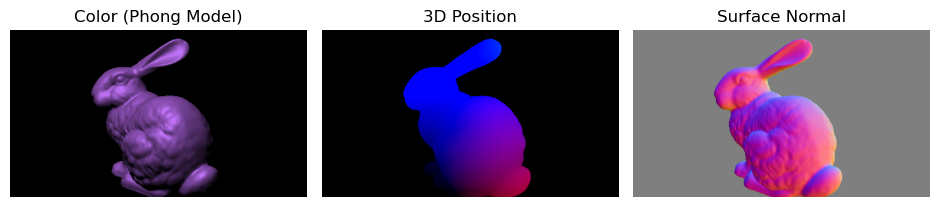

In [2]:
camera_pos = glm.vec3(2, -2, 1.5)
light_pos = glm.vec3(1, -2.0, 3.5)
light_color = glm.vec3(0.8, 0.8, 0.8)

colors = np.load(os.path.join(helpers.dataset_folder, "week5", "shaded_bunny.npy"))
positions = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week5", "position0001.exr"), 0.25, nn_interpolation=True)
normals = helpers.imread_hdr(os.path.join(helpers.dataset_folder, "week5", "normal0001.exr"), 0.25, nn_interpolation=True)

helpers.show_images({
    "Color (Phong Model)": np.clip(colors, 0, 1),
    "3D Position": positions,
    "Surface Normal": normals / 2 + 0.5
}, nrows=1, ncols=3)

### Exercise 4 (2 points)
Your job is to find a material which matches the appearance of the bunny in the given image. Find the parameters $k_s$ and $k_d$ of the Phong model that were used to render the images by formulating the problem as a linear system and finding the least squares solution. Each pixel that shows the bunny (= not background pixels) should add contraints to the linear system.

$t$ is assumed to already be known and for this exercise is guaranteed to be correct. The light is provided so that you can compute the incoming light- direction&color at any point.

Construct a linear system to find $k_d$ and $k_s$ and solve it using `np.linalg.lstsq(A, b)[0]`.

In [3]:
def solve_phong_kd_ks(t, light_color, light_position, observer_position, pixels):
    
    kd = []
    ks = []
    
    for c in range(3):  
        A = []
        b = []

        for surface_normal, surface_position, observed_color in pixels:
            L = light_position - surface_position
            L = L / np.linalg.norm(L)
            
            V = observer_position - surface_position
            V = V / np.linalg.norm(V)
            
            R = 2 * np.dot(surface_normal, L) * surface_normal - L
            
            D = np.dot(L, surface_normal)
            S = np.dot(R, V) ** t
            

            A.append([D * light_color[c], S * light_color[c]])
            b.append(observed_color[c])
    
        A = np.array(A)
        b = np.array(b)
        
        kdks, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        # print(f"Estimated kd and ks for channel {c}: {kdks}")
                
        kd.append(kdks[0])
        ks.append(kdks[1])
        
    # print(f"Estimated kd: {kd}")
    # print(f"Estimated ks: {ks}")    
    return np.array(kd), np.array(ks)


# Get surface normal, surface position and observed color for each non-background pixel.
pixels = zip(normals.reshape(-1, 3), positions.reshape(-1, 3), colors.reshape(-1, 3))
pixels = [pixel for pixel in pixels if glm.dot(pixel[0], pixel[0]) > 0]
# Filter out edge cases where the light is behind the surface of the object.
pixels = [(n, s, c) for n, s, c in pixels if np.dot(n, light_pos - s) > 0.01]

import warnings
with warnings.catch_warnings():
    # Ignore warnings about "FutureWarning: `rcond` parameter will change to the default ..." in np.linalg.lstsq
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    kd_estimate, ks_estimate = solve_phong_kd_ks(5, light_color, light_pos, camera_pos, pixels)

print(f"Your estimated parameters: kd={kd_estimate}, ks={ks_estimate}")
print(f"Actual parameters: kd=[0.7, 0.4, 0.9], ks=[0.3, 0.2, 0.4]\n")

Your estimated parameters: kd=[0.70536767 0.40357846 0.90715688], ks=[0.27941681 0.18627786 0.37255573]
Actual parameters: kd=[0.7, 0.4, 0.9], ks=[0.3, 0.2, 0.4]



### Tests of exercise 4
The parameters `kd` and `ks` that your solution returns should be within $0.0001$ of the actual values.

In [4]:
# Add your own tests here.

In [5]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


## Computing shininess
The shininess term $t$ does not have a linear relation to the output. This problem is very common in more complex reflection models which are never just a linear blend of parameters.

$$
k_d I (L \cdot N) + k_s I (E \cdot R)^t
$$

Assume that we know $k_d$ and $k_s$, making $t$ the only unknown variable. We can reformulate the Phong formula (above) such that it states $t=\text{...}$ . With this we can estimate $t$ for every pixel & color channel. Take the average over all (non background) pixels to get an accurate estimate of the shininess value $t$ of the sphere.

### Exercise 5 (2 points)
Derive the formula for $t$ given $k_d$ and $k_s$ and use it to compute the mean estimated t value for all pixels. You may assume that the provided values of $k_d$ and $k_s$ exactly match the provided images.

**Tip**: There are many pixels which have an extremely low specular contribution. Trying to estimate $t$ from these pixels will lead to mathematical issues (e.g. division by zero or logarithm of zero) or numerical precision limitations (division by very small number). We recommend skipping these pixels as they do not contribute to an accurate estimate of $t$.

In [6]:
def solve_phong_t(kd, ks, light_color, light_position, observer_position, pixels):
    t_values = []
    
    for surface_normal, surface_position, observed_color in pixels:
        
        #light direction L
        L = light_position - surface_position
        L = L / np.linalg.norm(L)
        
        # view direction
        V = observer_position - surface_position
        V = V / np.linalg.norm(V)
        
        # refl
        R = 2 * np.dot(surface_normal, L) * surface_normal - L
        
        D = np.dot(L, surface_normal)
        S = np.dot(R, V)
        
        # Does this even do anything?
        # if S <= 0 or np.dot(observed_color, light_color) <= 0:
        #     continue
        
        t_pixel = []
        
        # for each channel
        for c in range(3): 
            I = observed_color[c]
            kd_c = kd[c]
            ks_c = ks[c]
            #Does not change the outcome, but what if that S -> 0?
            # try:
            t_c = (np.log(I - kd_c * D * light_color[c]) - np.log(ks_c * light_color[c])) / np.log(S)
            t_pixel.append(t_c)
            # except (ValueError, ZeroDivisionError):
            #     continue
        
        if t_pixel:
            t_values.append(np.mean(t_pixel))
    
    # estimations, note, remove nans a[~np.isnan(a).all(axis=1)]
    t = t_values[~np.isnan(t_values).all(axis=0)]
    t = np.mean(t) 

    
    return t

# Get surface normal, surface position and observed color for each non-background pixel.
pixels = zip(normals.reshape(-1, 3), positions.reshape(-1, 3), colors.reshape(-1, 3))
pixels = [pixel for pixel in pixels if glm.dot(pixel[0], pixel[0]) > 0]
# Filter out edge cases where the light is behind the surface of the object.
pixels = [(n, s, c) for n, s, c in pixels if np.dot(n, light_pos - s) > 0.01]
t_estimate = solve_phong_t(glm.vec3(0.7, 0.4, 0.9), glm.vec3(0.3, 0.2, 0.4), light_color, light_pos, camera_pos, pixels)

print(f"Your estimated parameters: t={t_estimate}")
print(f"Actual parameters: t=5")

C:\Users\midas\AppData\Local\Temp\ipykernel_5204\2243331404.py:33: RuntimeWarning: divide by zero encountered in log
  t_c = (np.log(I - kd_c * D * light_color[c]) - np.log(ks_c * light_color[c])) / np.log(S)
C:\Users\midas\AppData\Local\Temp\ipykernel_5204\2243331404.py:33: RuntimeWarning: invalid value encountered in log
  t_c = (np.log(I - kd_c * D * light_color[c]) - np.log(ks_c * light_color[c])) / np.log(S)
C:\Users\midas\AppData\Local\Temp\ipykernel_5204\2243331404.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  t_c = (np.log(I - kd_c * D * light_color[c]) - np.log(ks_c * light_color[c])) / np.log(S)


Your estimated parameters: t=4.99357996902267
Actual parameters: t=5


C:\Users\midas\AppData\Local\Temp\ipykernel_5204\2243331404.py:42: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  t = t_values[~np.isnan(t_values).all(axis=0)]


### Tests of exercise 5
Your method should be able to detect the $t$ value with high accuracy ($<0.001$)

In [7]:
# Add your own tests here.

In [8]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL
